In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

adc.json  drive  sample_data


# K En Yakın Komşu

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## KNN

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Modelleme Ve Tahmin

In [ ]:
knn_model = KNeighborsRegressor().fit(X_train, y_train)
knn_model

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
knn_model.predict(X_test)[0:5]

array([ 510.3334,  808.3334,  772.5   ,  125.5   , 1005.    ])

In [ ]:
# Tahmin edilen modelleri kayıt edelim değişkene
y_pred = knn_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

426.6570764525201

## Model Tuning

In [ ]:
RMSE = []

for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors= k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    RMSE.append(rmse)
    print("k=", k, "için RMSE değeri:", rmse)

k= 1 için RMSE değeri: 455.03925390751965
k= 2 için RMSE değeri: 415.99629571490965
k= 3 için RMSE değeri: 420.6765370082348
k= 4 için RMSE değeri: 428.8564674588792
k= 5 için RMSE değeri: 426.6570764525201
k= 6 için RMSE değeri: 423.5071669008732
k= 7 için RMSE değeri: 414.9361222421057
k= 8 için RMSE değeri: 413.7094731463598
k= 9 için RMSE değeri: 417.84419990871265
k= 10 için RMSE değeri: 421.6252180741266


In [ ]:
# GridSearchCV Grid ızgara demek
# Belirlemeye çalıştığımız hiper paremetrelerin değerlerini belirlemek içinkullanılan fonksiyondur
knn_params = {"n_neighbors": np.arange(1,30,1)}

In [ ]:
knn = KNeighborsRegressor()
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10).fit(X_train, y_train)

In [ ]:
knn_cv_model.best_params_ # yukarıda for ile yaptığımızı burada daha hızlı bir şekilde yaptık

{'n_neighbors': 8}

In [ ]:
# Final model
knn_tuned = KNeighborsRegressor(n_neighbors = knn_cv_model.best_params_["n_neighbors"]).fit(X_train, y_train)
knn_tuned

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                    weights='uniform')

In [ ]:
# Test hatasını bulalım
y_pred= knn_tuned.predict(X_test)


In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

413.7094731463598

# Destek Vektör Regresyon

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Seti yükleme

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

NameError: ignored

## Model ve Tahmin

In [ ]:
svr_model = SVR("linear").fit(X_train, y_train) # linear kernel demek örenek olarak rbf de var
svr_model

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
svr_model.predict(X_train)[0:5]

array([219.32622169, 702.4303869 , 623.2055964 , 153.77538476,
       463.15190834])

In [ ]:
svr_model.predict(X_test)[0:5]

array([679.14754685, 633.72883069, 925.68640849, 270.28463621,
       530.26659184])

In [ ]:
svr_model.intercept_

array([-80.15196151])

In [ ]:
svr_model.coef_

array([[ -1.21839037,   6.09602969,  -3.67574533,   0.14217075,
          0.51435919,   1.28388986,  12.55922537,  -0.08693755,
          0.46597184,   2.98259944,   0.52944523,  -0.79820799,
         -0.16015534,   0.30872794,   0.28842348,  -1.79560067,
          6.41868985, -10.74313783,   1.33374317]])

In [ ]:
# Test hatası
y_pred = svr_model.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

370.04084185624924

## model tuning

In [ ]:
svr_model = SVR("linear")
svr_model

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
#aranacak parametreler
svr_params = {"C": [0.1,0.5,1,3]}

In [ ]:
# K katlı çarpaz doğrulama ile deneme işlemi
svr_cv_model = GridSearchCV(svr_model, svr_params, cv = 5).fit(X_train, y_train)
# svr_cv_model = GridSearchCV(svr_model, svr_params, cv = 5, verbose =2, n_jobs = -1).fit(X_train, y_train)
# verbose=2; bize raporlama yapar, n_jbos=-1 ise bizim işlemciği maksimumda çalıştırır. 

In [ ]:
svr_cv_model.best_params_ #C nin en iyi olduğu yerde değeri bulamak için 

{'C': 0.5}

In [ ]:
svr_tuned = SVR("linear", C= 0.5).fit(X_train, y_train)

In [ ]:
y_pred = svr_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

367.9874739022889

# Yapay sinir ağları

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Seti yükleme

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model ve Tahmin

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train) # X eğitim seti ölçeklendirilmiştir.
X_test_scaled = scaler.transform(X_test)

In [ ]:
#mlp= çok katmanlı algılayıcı
mlp_model = MLPRegressor().fit(X_train_scaled, y_train)
mlp_model

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
# Hiç bir bilgimiz olmadan model tahmin etme işlemi yapalım
mlp_model.predict(X_test_scaled)[0:5]

array([22.69516654, 46.81605878, 73.22358216, 16.02380724, 18.79984622])

In [ ]:
y_pred = mlp_model.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test, y_pred))

658.2816316993706

## Model Tuning

In [ ]:
mlp_params = {"alpha": [0.1, 0.01, 0.02, 0.001, 0.0001],
              "hidden_layer_sizes": [(10,20), (5,5), (100,100)]}

In [ ]:
mlp_cv_model = GridSearchCV(mlp_model, mlp_params, cv = 10, verbose = 2, n_jobs= -1).fit(X_train_scaled, y_train)

NameError: ignored

In [ ]:
# en iyi parametre değerlerini bulma
mlp_cv_model.best_params_

In [ ]:
#Fİnal model
mlp_tuned = MLPRegressor(alpha= 0.0001, hidden_layer_sizes= (100,100)).fit(X_train_scaled, y_train)

In [ ]:
y_pred =mlp_tuned.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test, y_pred))

# CART Classification and Regression Tree

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Seti yükleme

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train = pd.DataFrame(X_train["Hits"])
X_test = pd.DataFrame(X_test["Hits"])

## Model ve Tahmin

In [ ]:
cart_model = DecisionTreeRegressor(max_leaf_nodes= 10) # max_leaf_models = maksimum yaprak sayısı
cart_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

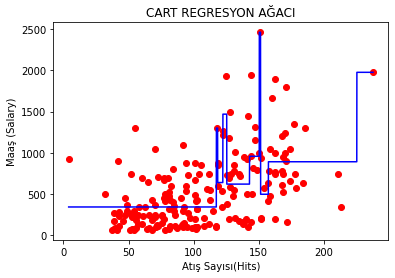

In [ ]:
# Grafikte Gösterim
X_grid = np.arange(min(np.array(X_train)),max(np.array(X_train)), 0.01)
X_grid = X_grid.reshape((len(X_grid),1))

plt.scatter(X_train, y_train, color = 'red')

plt.plot(X_grid, cart_model.predict(X_grid), color = 'blue')

plt.title('CART REGRESYON AĞACI')
plt.xlabel('Atış Sayısı(Hits)')
plt.ylabel('Maaş (Salary)');

In [ ]:
# tahmin
#tek depişkenli tahmin
cart_model.predict(X_test)[0:5]

array([621.96792308, 958.61111111, 621.96792308, 345.20115517,
       345.20115517])

In [ ]:
y_pred = cart_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

486.34593105235456

In [ ]:
# tüm değişkenler
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
cart_model = DecisionTreeRegressor().fit(X_train, y_train)

In [ ]:
y_pred = cart_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

534.9053378515027

## Model Tuning

In [ ]:
cart_model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
cart_model = DecisionTreeRegressor(max_depth= 3).fit(X_train, y_train) # max_depth ağacın ne kadar derinleşeceğini söyler
y_pred = cart_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

391.5530522634767

In [ ]:
cart_params = {"max_depth": [2,3,4,5,10,20],
               "min_samples_split": [2,10,5,30,50,10]}

In [ ]:
cart_model = DecisionTreeRegressor()

In [ ]:
cart_cv_model = GridSearchCV(cart_model, cart_params, cv =10).fit(X_train, y_train)

In [ ]:
cart_cv_model.best_params_

{'max_depth': 5, 'min_samples_split': 50}

In [ ]:
#Final model
cart_tuned = DecisionTreeRegressor(max_depth= 4, min_samples_split= 50).fit(X_train, y_train)

In [ ]:
y_pred = cart_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

361.0876906511434

# Random Forests

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Seti yükleme

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model ve Tahmin

In [ ]:
rf_model = RandomForestRegressor(random_state= 42).fit(X_train, y_train) # her defasında farklılık olmuşmaması için
rf_model

In [ ]:
y_pred = rf_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

344.73852779396566

## Model Tuning

In [ ]:
rf_params = {"max_depth": [5,8,10],
             "max_features": [2,5,10], 
             "n_estimators": [200, 500, 1000, 2000],
             "min_samples_split": [2,10,80, 100]}

In [ ]:
rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs= -1, verbose= 2).fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 22.5min finished


In [ ]:
rf_cv_model.best_params_

{'max_depth': 8,
 'max_features': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
rf_model = RandomForestRegressor(random_state= 42, max_depth = 8,
                                 min_samples_split = 2, n_estimators= 200)
rf_tuned = rf_model.fit(X_train, y_train)

In [ ]:
y_pred = rf_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

342.41116104853967

## Değişken Önem Düzeyi

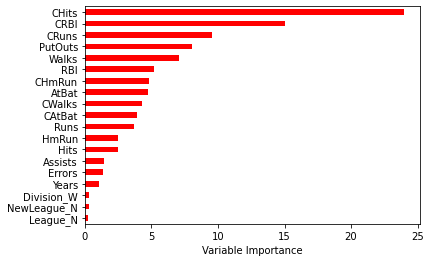

In [ ]:
Importance = pd.DataFrame({'Importance':rf_tuned.feature_importances_*100},
                          index = X_train.columns)
Importance.sort_values(by = 'Importance',
                       axis = 0,
                       ascending = True).plot(kind = 'barh', color = 'r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# Gradient Boosting Machines

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Seti yükleme

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model ve Tahmin

In [ ]:
gbm_model = GradientBoostingRegressor().fit(X_train, y_train)
gbm_model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred = gbm_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

353.390058937434

## Model Tuning

In [ ]:
gbm_params = {"learning_rate": [0.001,0.1,0.01],
              "max_depth": [3,5,8],
              "n_estimators": [100, 200, 500],
              "subsample": [1,0.5,0.8],
              "loss": ["ls", "lad", "quantile"]}

In [ ]:
gbm_model = GradientBoostingRegressor().fit(X_train, y_train)

In [ ]:
gbm_cv_model = GridSearchCV(gbm_model, gbm_params, 
                            cv = 10, n_jobs=-1, verbose= 2).fit(X_train, y_train)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 15.6min finished


In [ ]:
gbm_cv_model.best_params_

{'learning_rate': 0.1,
 'loss': 'lad',
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1}

In [ ]:
gbm_tuned = GradientBoostingRegressor(learning_rate= 0.1, loss = "lad", max_depth = 3,
                                      n_estimators = 200, subsample = 1).fit(X_train, y_train)

In [ ]:
y_pred = gbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

## Değişkenlerin Önem Düzeyi

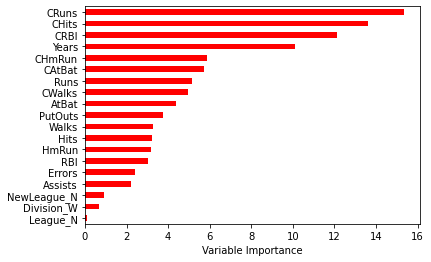

In [ ]:
Importance = pd.DataFrame({'Importance':gbm_tuned.feature_importances_*100},
                          index = X_train.columns)
Importance.sort_values(by = 'Importance',
                       axis = 0,
                       ascending = True).plot(kind = 'barh', color = 'r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# XGBoost

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR
!pip install xgboost
import xgboost
from xgboost import XGBRegressor

In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Seti yükleme

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model Ve Tahmin

In [ ]:
xgb = XGBRegressor().fit(X_train, y_train)

[22:15:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred = xgb.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

359.91750599447033

## Model Tuning

In [ ]:
xgb_params = {"learning_rate": [0.1,0.01,0.5],
              "max_depth": [2,3,4,5,8],
              "n_estimators": [100,200,500,1000],
              "colsample_bytree":[0.4,0.4,1]} # bu oluşturalacak olan ağaçlarda alt küme belirtir

In [ ]:
xgb_cv_model = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs= -1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1737 tasks      | elapsed:  3.4min


[22:24:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  3.5min finished


In [ ]:
xgb_cv_model.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 1000}

In [ ]:
xgb_tuned = XGBRegressor(colsample_bytree= 0.4, learning_rate= 0.1, max_depth= 2,
                         n_estimators = 1000).fit(X_train, y_train)

[22:25:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred= xgb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

343.5566804929871

## Değişkenlerin Önem Düzeyi

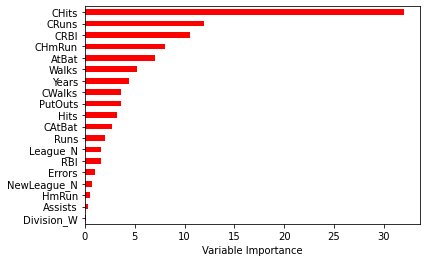

In [ ]:
Importance = pd.DataFrame({'Importance':xgb_tuned.feature_importances_*100},
                          index = X_train.columns)
Importance.sort_values(by = 'Importance',
                       axis = 0,
                       ascending = True).plot(kind = 'barh', color = 'r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# Light GBM

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR
!pip install lightgbm
import lightgbm
from lightgbm import LGBMRegressor

In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Seti yükleme

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model ve Tahmin

In [ ]:
lgb_model = LGBMRegressor().fit(X_train, y_train)
lgb_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = lgb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

363.8712087611089

## Model Tuning

In [ ]:
lgbm_params = {"learning_rate": [0.01, 0.1, 0.5, 1],
               "n_estimation": [20,40,100,200,500,100],
               "max_depth": [1,2,3,4,5,6,7,8,9,10]}

In [ ]:
lgbm_cv_model = GridSearchCV(lgb_model, lgbm_params,
                             cv = 10, n_jobs = -1,
                             verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   39.7s finished


In [ ]:
lgbm_cv_model.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimation': 20}

In [ ]:
lgbm_tuned = LGBMRegressor(learning_rate=0.1, max_depth=4, n_estimators=20).fit(X_train, y_train)

In [ ]:
y_pred = lgbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

371.34440690249164

## Değişkenlerin Önem Düzeyi

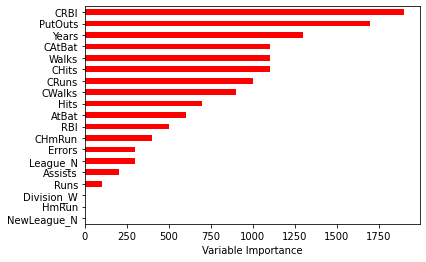

In [ ]:
Importance = pd.DataFrame({'Importance':lgbm_tuned.feature_importances_*100},
                          index = X_train.columns)
Importance.sort_values(by = 'Importance',
                       axis = 0,
                       ascending = True).plot(kind = 'barh', color = 'r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# CatBoost

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR
!pip install catboost
import catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 69.2 MB 5.6 kB/s 


In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Seti yükleme

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model ve Tahmin

In [ ]:
catb_model = CatBoostRegressor().fit(X_train, y_train)

In [ ]:
y_pred = catb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

350.2683163098795

## Model Tuning

In [ ]:
cat_params = {"iterations": [200,500,100], # iterations ağaç sayısıdır
              "learning_rate": [0.01,0.1],
              "depth": [3,6,8]} 

In [ ]:
catb_model = CatBoostRegressor()

In [ ]:
catb_cv_model = GridSearchCV( catb_model, cat_params,
                             cv= 5, n_jobs=-1, verbose=2).fit(X_train, y_train)

In [ ]:
catb_cv_model.best_params_

{'depth': 3, 'iterations': 200, 'learning_rate': 0.1}

In [ ]:
catb_tuned= CatBoostRegressor(depth =3, iterations = 500,
                              learning_rate = 0.1).fit(X_train, y_train)

In [ ]:
y_pred = catb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

336.40041748521486

# Makine öğrenmesi görevlerinin otomatikleştirilmesi

## Kütüphane

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler #Standartlaştırma işlemleri için
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR
!pip install catboost
import catboost
from catboost import CatBoostRegressor
!pip install lightgbm
import lightgbm
from lightgbm import LGBMRegressor
!pip install xgboost
import xgboost
from xgboost import XGBRegressor

In [ ]:
# uyarı engelemek için
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Seti yükleme

In [ ]:
df = pd.read_csv('/content/drive/Colab Notebooks/MakineOgrenmesi/Hitters.csv')
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])


## Otomatikleştirme (manuel kısım)

In [ ]:
def compML(df, y, alg):
  #Train-Test ayrımı
    y = df[y]
    X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
    X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    #Modelleme
    model = alg().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE =np.sqrt(mean_squared_error(y_test, y_pred))
    model_ismi = alg.__name__
    print(model_ismi, "Modeli Test Hatası:", RMSE)
    return RMSE 

In [ ]:
compML(df, "Salary", LGBMRegressor)

LGBMRegressor Modeli Test Hatası: 363.8712087611089


363.8712087611089

## Otomatikleştirme full otoamatik

In [ ]:
models = [LGBMRegressor, XGBRegressor, GradientBoostingRegressor,
          RandomForestRegressor, DecisionTreeRegressor, MLPRegressor,
          KNeighborsRegressor, SVR]

In [ ]:
for i in models:
    compML(df, "Salary", i)

LGBMRegressor Modeli Test Hatası: 363.8712087611089
[15:24:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor Modeli Test Hatası: 359.91750599447033
GradientBoostingRegressor Modeli Test Hatası: 349.3052188151684
RandomForestRegressor Modeli Test Hatası: 338.7303983281385
DecisionTreeRegressor Modeli Test Hatası: 490.20035881281456
MLPRegressor Modeli Test Hatası: 431.51452731079684
KNeighborsRegressor Modeli Test Hatası: 426.6570764525201
SVR Modeli Test Hatası: 460.0032657244849
